# Predicting Airbnb Prices

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Jakarta is the capital and largest city of Indonesia where over 10 million people live and it has a population density of 14,464 people per square kilometer. Jakarta consists of five administrative cities and one administrative regency. The administrative cities of Jakarta are: Central Jakarta, West Jakarta, South Jakarta, East Jakarta and North Jakarta. The only administrative regency in Jakarta is the Thousand Islands. In this project, I limit the scope of my research to the districts of Central Jakarta.

As the capital city of Indonesia, Jakarta is one of the most popular destinations in Indonesia. Thus, there is a lot of potential profit that could be obtained by property owners through listing a home on Airbnb in Jakarta. However, it’s hard for a new host to determine the rate for nightly stay. This research aims to solve this problem by predicting an efficient rate by using machine learning model which is trained with data from Airbnb listings.

## Data <a name="data"></a>

### Import Necessary Libraries

In [1]:
import pandas as pd # Library for data analysis
import numpy as np # Library to handle data in a vectorized manner
import requests # Library to handle requests
from pandas.io.json import json_normalize # Library to transform json file into a pandas dataframe 

Define location queries.

In [2]:
locations = ['Cempaka+Putih+Barat,+Central+Jakarta', 'Cempaka+Putih+Timur,+Central+Jakarta', 'Rawasari,+Central+Jakarta', 'Cideng,+Central+Jakarta', 'Duri+Pulo,+Central+Jakarta', 'Gambir,+Central+Jakarta', 'Kebon+Kelapa,+Central+Jakarta', 'Petojo+Selatan,+Central+Jakarta', 'Petojo+Utara,+Central+Jakarta', 'Galur,+Central+Jakarta', 'Johar+Baru,+Central+Jakarta', 'Kampung+Rawa,+Central+Jakarta', 'Tanah+Tinggi,+Central+Jakarta', 'Cempaka+Baru,+Central+Jakarta', 'Gunung+Sahari+Selatan,+Central+Jakarta', 'Harapan+Mulya,+Central+Jakarta', 'Kebon+Kosong,+Central+Jakarta', 'Kemayoran,+Central+Jakarta', 'Serdang,+Central+Jakarta', 'Sumur+Batu,+Central+Jakarta', 'Utan+Panjang,+Central+Jakarta', 'Cikini,+Central+Jakarta', 'Gondangdia,+Central+Jakarta', 'Kebon+Sirih,+Central+Jakarta', 'Menteng,+Central+Jakarta', 'Pegangsaan,+Central+Jakarta', 'Gunung+Sahari+Utara,+Central+Jakarta', 'Karang+Anyar,+Central+Jakarta', 'Kartini,+Central+Jakarta', 'Mangga+Dua+Selatan,+Central+Jakarta', 'Pasar+Baru,+Central+Jakarta', 'Bungur,+Central+Jakarta', 'Kenari,+Central+Jakarta', 'Kramat,+Central+Jakarta', 'Kwitang,+Central+Jakarta', 'Paseban,+Central+Jakarta', 'Senen,+Central+Jakarta', 'Bendungan+Hilir,+Central+Jakarta', 'Gelora,+Central+Jakarta', 'Kampung+Bali,+Central+Jakarta', 'Karet+Tengsin,+Central+Jakarta', 'Kebon+Kacang,+Central+Jakarta', 'Kebon+Melati,+Central+Jakarta', 'Petamburan,+Central+Jakarta']

### Use Airbnb API to Get Listings Data

Create a function to extract relevant data from the result requested to Airbnb API.

In [3]:
def getListings(locations=[]):
    
    _FORMAT = 'for_explore_search_web'
    ITEMS_PER_GRID = '300'
    KEY = 'd306zoyjsyarp7ifhu67rjxn52tv0t20'
    SECTION_OFFSET = '4'
    SUPPORT_FOR_YOU_V3 = 'true'
    TAB_ID = 'home_tab'
    TIMEZONE_OFFSET = '300'
    VERSION = '1.3.4'
    CURRENCY = 'IDR'

    listings_list = []

    for location in locations:

        # Create the API request URL
        url = 'https://api.airbnb.com/v2/explore_tabs?_format={}&items_per_grid={}&key={}&location={}&section_offset={}&supports_for_you_v3={}&tab_id={}' \
              '&timezone_offset={}&version={}&currency={}'.format(
            _FORMAT, 
            ITEMS_PER_GRID, 
            KEY, 
            location, 
            SECTION_OFFSET, 
            SUPPORT_FOR_YOU_V3, 
            TAB_ID, 
            TIMEZONE_OFFSET, 
            VERSION, 
            CURRENCY)
        
        # Make the GET request
        results = requests.get(url).json()['explore_tabs'][0]['sections'][0]['listings']
        
        # Return only relevant information for each location
        listings_list.append([(
            listing['listing'].get('id', np.nan),
            location.replace('+', ' '),
            listing['listing'].get('lat', np.nan),
            listing['listing'].get('lng', np.nan),
            listing['listing'].get('person_capacity', np.nan),
            listing['listing'].get('bathrooms', np.nan),
            listing['listing'].get('bedrooms', np.nan),
            listing['listing'].get('beds', np.nan),
            listing['listing'].get('reviews_count', np.nan),
            listing['listing'].get('room_type', np.nan),
            listing['listing'].get('avg_rating', np.nan),
            listing['listing'].get('min_nights', np.nan),
            listing['listing'].get('max_nights', np.nan),
            listing['pricing_quote']['rate'].get('amount', np.nan),
            listing['pricing_quote'].get('rate_type', np.nan)
        ) for listing in results])
    
    listings = pd.DataFrame([item for listing_list in listings_list for item in listing_list])
    listings.columns = ['Listing ID', 'Location', 'Latitude', 'Longitude', 'Number of Guests', 'Bathrooms', 'Bedrooms', \
                       'Beds', 'Review Count', 'Room Type', 'Rating', 'Minimum Nights', 'Maximum Nights', 'Rate (Rp)', 'Rate Type']
    
    return(listings)

Run the above function for each location and create listings dataframe.

In [4]:
listings_df = getListings(locations=locations)

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(2154, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
0,18378734,"Cempaka Putih Barat, Central Jakarta",-6.19312,106.85025,2,1.0,0.0,1.0,144,Entire home/apt,4.67,2,1125,270000.0,nightly
1,32297852,"Cempaka Putih Barat, Central Jakarta",-6.19104,106.87336,2,1.0,0.0,1.0,20,Entire home/apt,5.00,2,360,169225.0,nightly
2,19820937,"Cempaka Putih Barat, Central Jakarta",-6.19815,106.85105,2,1.0,0.0,2.0,70,Entire home/apt,4.59,4,30,166348.0,nightly
3,40735320,"Cempaka Putih Barat, Central Jakarta",-6.18998,106.87367,2,1.0,0.0,1.0,4,Entire home/apt,5.00,7,1125,200000.0,nightly
4,5157038,"Cempaka Putih Barat, Central Jakarta",-6.19481,106.85622,3,1.0,1.0,1.0,75,Entire home/apt,4.84,4,1125,335052.0,nightly


Drop all duplicate values.

In [5]:
# Sort dataframe according to Location
listings_df.sort_values('Location', inplace=True)

# Dropping all duplicate values except the first value
listings_df.drop_duplicates(subset='Listing ID', keep='first', inplace=True)

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(727, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1812,22987741,"Bendungan Hilir, Central Jakarta",-6.21335,106.81134,3,1.0,2.0,2.0,25,Entire home/apt,4.76,1,1125,700000.0,nightly
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1825,22183883,"Bendungan Hilir, Central Jakarta",-6.20685,106.81307,1,1.0,1.0,1.0,0,Private room,NaN,1,1125,150000.0,nightly
1824,4619772,"Bendungan Hilir, Central Jakarta",-6.21704,106.80577,2,1.0,1.0,1.0,17,Entire home/apt,4.76,4,1125,455560.0,nightly
1823,40116584,"Bendungan Hilir, Central Jakarta",-6.20918,106.80547,2,1.0,1.0,1.0,0,Private room,NaN,2,60,180000.0,nightly


Evaluate missing data.

In [6]:
missing_data = listings_df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())  
    print('')

Listing ID
False    727
Name: Listing ID, dtype: int64

Location
False    727
Name: Location, dtype: int64

Latitude
False    727
Name: Latitude, dtype: int64

Longitude
False    727
Name: Longitude, dtype: int64

Number of Guests
False    727
Name: Number of Guests, dtype: int64

Bathrooms
False    727
Name: Bathrooms, dtype: int64

Bedrooms
False    724
True       3
Name: Bedrooms, dtype: int64

Beds
False    719
True       8
Name: Beds, dtype: int64

Review Count
False    727
Name: Review Count, dtype: int64

Room Type
False    727
Name: Room Type, dtype: int64

Rating
False    392
True     335
Name: Rating, dtype: int64

Minimum Nights
False    727
Name: Minimum Nights, dtype: int64

Maximum Nights
False    727
Name: Maximum Nights, dtype: int64

Rate (Rp)
False    727
Name: Rate (Rp), dtype: int64

Rate Type
False    727
Name: Rate Type, dtype: int64



Because the quantity of missing data in the Rating column is significant, drop rows with missing value.

In [7]:
listings_df.dropna(subset=['Rating'], axis=0, inplace=True)

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(392, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1812,22987741,"Bendungan Hilir, Central Jakarta",-6.21335,106.81134,3,1.0,2.0,2.0,25,Entire home/apt,4.76,1,1125,700000.0,nightly
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1824,4619772,"Bendungan Hilir, Central Jakarta",-6.21704,106.80577,2,1.0,1.0,1.0,17,Entire home/apt,4.76,4,1125,455560.0,nightly
1821,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
1819,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly


Evaluate missing data once again.

In [8]:
missing_data = listings_df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())  
    print('')

Listing ID
False    392
Name: Listing ID, dtype: int64

Location
False    392
Name: Location, dtype: int64

Latitude
False    392
Name: Latitude, dtype: int64

Longitude
False    392
Name: Longitude, dtype: int64

Number of Guests
False    392
Name: Number of Guests, dtype: int64

Bathrooms
False    392
Name: Bathrooms, dtype: int64

Bedrooms
False    392
Name: Bedrooms, dtype: int64

Beds
False    391
True       1
Name: Beds, dtype: int64

Review Count
False    392
Name: Review Count, dtype: int64

Room Type
False    392
Name: Room Type, dtype: int64

Rating
False    392
Name: Rating, dtype: int64

Minimum Nights
False    392
Name: Minimum Nights, dtype: int64

Maximum Nights
False    392
Name: Maximum Nights, dtype: int64

Rate (Rp)
False    392
Name: Rate (Rp), dtype: int64

Rate Type
False    392
Name: Rate Type, dtype: int64



Drop data with Room Type: Shared Room.

In [9]:
listings_df = listings_df[listings_df['Room Type'] != 'Shared room']

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(389, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1812,22987741,"Bendungan Hilir, Central Jakarta",-6.21335,106.81134,3,1.0,2.0,2.0,25,Entire home/apt,4.76,1,1125,700000.0,nightly
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1824,4619772,"Bendungan Hilir, Central Jakarta",-6.21704,106.80577,2,1.0,1.0,1.0,17,Entire home/apt,4.76,4,1125,455560.0,nightly
1821,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
1819,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly


Drop data with Number of Guests more than 4.

In [10]:
listings_df = listings_df[listings_df['Number of Guests'] < 5]

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(342, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1812,22987741,"Bendungan Hilir, Central Jakarta",-6.21335,106.81134,3,1.0,2.0,2.0,25,Entire home/apt,4.76,1,1125,700000.0,nightly
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1824,4619772,"Bendungan Hilir, Central Jakarta",-6.21704,106.80577,2,1.0,1.0,1.0,17,Entire home/apt,4.76,4,1125,455560.0,nightly
1821,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
1819,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly


Drop data with Minimum Nights more than 3.

In [11]:
listings_df = listings_df[listings_df['Minimum Nights'] < 4]

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(282, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1812,22987741,"Bendungan Hilir, Central Jakarta",-6.21335,106.81134,3,1.0,2.0,2.0,25,Entire home/apt,4.76,1,1125,700000.0,nightly
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1821,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
1819,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly
1827,12855114,"Bendungan Hilir, Central Jakarta",-6.19405,106.81437,2,1.0,1.0,1.0,136,Entire home/apt,4.90,2,1125,300000.0,nightly


Remove outliers with IQR.

In [12]:
Q1 = listings_df['Rate (Rp)'].quantile(0.25)
Q3 = listings_df['Rate (Rp)'].quantile(0.75)
IQR = Q3 - Q1
filter = (Q1-IQR <= listings_df['Rate (Rp)']) & (listings_df['Rate (Rp)'] <= Q3+IQR)

listings_df = listings_df[filter]

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(253, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
1826,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1821,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
1819,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly
1827,12855114,"Bendungan Hilir, Central Jakarta",-6.19405,106.81437,2,1.0,1.0,1.0,136,Entire home/apt,4.90,2,1125,300000.0,nightly
1811,40117294,"Bendungan Hilir, Central Jakarta",-6.20994,106.80463,3,1.0,1.0,1.0,6,Private room,4.83,2,60,210000.0,nightly


Reset index.

In [13]:
listings_df.reset_index(drop=True, inplace=True)

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(253, 15)


,Listing ID,Location,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Room Type,Rating,Minimum Nights,Maximum Nights,Rate (Rp),Rate Type
0,10344900,"Bendungan Hilir, Central Jakarta",-6.20482,106.81693,2,1.0,1.0,0.0,20,Entire home/apt,4.55,2,1125,213544.0,nightly
1,30411330,"Bendungan Hilir, Central Jakarta",-6.20469,106.81627,4,1.5,2.0,2.0,45,Entire home/apt,4.96,2,1125,435000.0,nightly
2,12575863,"Bendungan Hilir, Central Jakarta",-6.22503,106.81923,1,1.5,1.0,1.0,77,Entire home/apt,4.91,2,1125,350000.0,nightly
3,12855114,"Bendungan Hilir, Central Jakarta",-6.19405,106.81437,2,1.0,1.0,1.0,136,Entire home/apt,4.90,2,1125,300000.0,nightly
4,40117294,"Bendungan Hilir, Central Jakarta",-6.20994,106.80463,3,1.0,1.0,1.0,6,Private room,4.83,2,60,210000.0,nightly


Check data types for each column.

In [14]:
listings_df.dtypes

Listing ID            int64
Location             object
Latitude            float64
Longitude           float64
Number of Guests      int64
Bathrooms           float64
Bedrooms            float64
Beds                float64
Review Count          int64
Room Type            object
Rating              float64
Minimum Nights        int64
Maximum Nights        int64
Rate (Rp)           float64
Rate Type            object
dtype: object

Check the summary of the data.

In [15]:
listings_df.describe()

,Listing ID,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Rating,Minimum Nights,Maximum Nights,Rate (Rp)
count,2.530000e+02,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,2.519550e+07,-6.185002,106.834486,2.533597,1.059289,0.976285,1.371542,39.766798,4.720711,1.675889,858.312253,334130.869565
std,1.082139e+07,0.022538,0.024705,0.884084,0.200304,0.660260,0.687401,48.243152,0.327623,0.711088,447.315397,99716.990240
min,2.902830e+05,-6.242680,106.782030,1.000000,0.500000,0.000000,0.000000,3.000000,2.330000,1.000000,5.000000,142000.000000
25%,1.751365e+07,-6.196320,106.817020,2.000000,1.000000,1.000000,1.000000,9.000000,4.670000,1.000000,365.000000,261006.000000
50%,2.395856e+07,-6.191240,106.837750,2.000000,1.000000,1.000000,1.000000,26.000000,4.800000,2.000000,1125.000000,325000.000000
75%,3.527266e+07,-6.174650,106.850910,3.000000,1.000000,1.000000,2.000000,48.000000,4.910000,2.000000,1125.000000,400000.000000
max,4.284291e+07,-6.128390,106.893620,4.000000,2.000000,3.000000,4.000000,369.000000,5.000000,3.000000,1125.000000,585000.000000


Export the data into .csv.

In [16]:
listings_df.to_csv(r'~/Projects/predicting_airbnb_prices/data/central_jakarta_airbnb_listings.csv', index=False)

### Exploratory Data Analysis

In [17]:
from scipy import stats # Library to calculate Pearson Correlation Coefficient and P-Value

Remove features irrelevant with the analysis.

In [18]:
listings_df = listings_df[['Latitude', 'Longitude', 'Number of Guests', 'Bathrooms', 'Bedrooms', 'Beds', 'Review Count', 'Rating', 'Rate (Rp)']]

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(253, 9)


,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Rating,Rate (Rp)
0,-6.20482,106.81693,2,1.0,1.0,0.0,20,4.55,213544.0
1,-6.20469,106.81627,4,1.5,2.0,2.0,45,4.96,435000.0
2,-6.22503,106.81923,1,1.5,1.0,1.0,77,4.91,350000.0
3,-6.19405,106.81437,2,1.0,1.0,1.0,136,4.90,300000.0
4,-6.20994,106.80463,3,1.0,1.0,1.0,6,4.83,210000.0


Use Pearson Correlation Coefficient to calculate the correlation between features.

In [19]:
listings_df.corr()

,Latitude,Longitude,Number of Guests,Bathrooms,Bedrooms,Beds,Review Count,Rating,Rate (Rp)
Latitude,1.000000,0.246115,0.091678,-0.051144,0.171115,0.127403,-0.123064,-0.059362,-0.048218
Longitude,0.246115,1.000000,0.111295,-0.046689,0.124481,0.201726,-0.005999,0.041744,-0.122597
Number of Guests,0.091678,0.111295,1.000000,0.089546,0.558819,0.710709,0.040145,0.042662,0.388266
Bathrooms,-0.051144,-0.046689,0.089546,1.000000,0.205707,0.113174,-0.054618,-0.017879,0.047118
Bedrooms,0.171115,0.124481,0.558819,0.205707,1.000000,0.570317,-0.163374,-0.007810,0.191119
Beds,0.127403,0.201726,0.710709,0.113174,0.570317,1.000000,0.024042,0.067893,0.240012
Review Count,-0.123064,-0.005999,0.040145,-0.054618,-0.163374,0.024042,1.000000,0.118534,0.094474
Rating,-0.059362,0.041744,0.042662,-0.017879,-0.007810,0.067893,0.118534,1.000000,0.130303
Rate (Rp),-0.048218,-0.122597,0.388266,0.047118,0.191119,0.240012,0.094474,0.130303,1.000000


Use P-Value to calculate the statistical significance between features and Rate.

In [20]:
features = list(listings_df.columns.difference(['Latitude', 'Longitude', 'Rate (Rp)']))

for feature in features:
    pearson_coef, p_value = stats.pearsonr(listings_df[feature], listings_df['Rate (Rp)'])
    print("The Pearson Correlation Coefficient between " + feature + " and Rate (Rp) is", pearson_coef, ", with a P-value of P =", p_value)  

The Pearson Correlation Coefficient between Bathrooms and Rate (Rp) is 0.04711756475439233 , with a P-value of P = 0.4555743856243621
The Pearson Correlation Coefficient between Bedrooms and Rate (Rp) is 0.1911185955239919 , with a P-value of P = 0.0022651662958699777
The Pearson Correlation Coefficient between Beds and Rate (Rp) is 0.2400123560317196 , with a P-value of P = 0.00011562187328412912
The Pearson Correlation Coefficient between Number of Guests and Rate (Rp) is 0.3882660237263196 , with a P-value of P = 1.575012189309228e-10
The Pearson Correlation Coefficient between Rating and Rate (Rp) is 0.13030339651564837 , with a P-value of P = 0.03834222128713578
The Pearson Correlation Coefficient between Review Count and Rate (Rp) is 0.09447403051505836 , with a P-value of P = 0.1339738345518272


Since the Pearson Correlation Coefficient between 'Number of Guests' and 'Beds' is more than 0.7, exclude 'Beds' from analysis. Since the P-Value of 'Bathrooms' and 'Review Count' is higher than 0.1, exclude both of these features from analysis. 

In [21]:
listings_df = listings_df[['Latitude', 'Longitude', 'Number of Guests', 'Bedrooms', 'Rating', 'Rate (Rp)']]

# Check the size of the dataframe
print(listings_df.shape)
listings_df.head()

(253, 6)


,Latitude,Longitude,Number of Guests,Bedrooms,Rating,Rate (Rp)
0,-6.20482,106.81693,2,1.0,4.55,213544.0
1,-6.20469,106.81627,4,2.0,4.96,435000.0
2,-6.22503,106.81923,1,1.0,4.91,350000.0
3,-6.19405,106.81437,2,1.0,4.90,300000.0
4,-6.20994,106.80463,3,1.0,4.83,210000.0


## Methodology <a name="methodology"></a>

Data obtained from Airbnb API is limited to 50 per request. In order to obtain more data, instead of querying with ‘Central Jakarta’, districts within Central Jakarta were used for the queries. I then proceed by dropping the duplicate data. I evaluated the missing data. Because the quantity of missing data on  the ‘Rating’ feature is significant, I dropped the rows with missing data. After the missing data were processed, I dropped the data with ‘Room Type’ value of ‘Shared Room’, ‘Number of Guests’ more than 4, and ‘Minimum Nights’ more than 3. I then proceed by removing ‘Rate’ outliers with IQR. I then reset the index of dataframe.

After the data has been preprocessed, we remove irrelevant features. Then Pearson Correlation Coefficient was used to calculate the correlation between features. P-value was also used to calculate the statistical significance between features and Rates. The features that were used are ‘Latitude’, ‘Longitude’, ‘Number of Guests’, ‘Bedrooms’, ‘Rating’. Next, we normalize  and train test split the data. Finally we can implement KNN model.

## Analysis <a name="analysis"></a>

### Import Necessary Libraries

In [22]:
import matplotlib.pyplot as plt # Library for data visualization
from sklearn import preprocessing # Library to normalize data
from sklearn.model_selection import train_test_split # Library for train test split data
from sklearn import neighbors # Library for KNN model
from sklearn.metrics import mean_squared_error # Library to calculate MSE
from math import sqrt # Library for square root
from sklearn.model_selection import GridSearchCV # Library for grid search
%matplotlib inline

Explore data using visualization technique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f4064f220>]],
      dtype=object)

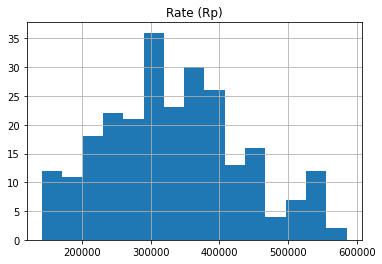

In [23]:
listings_df.hist(column='Rate (Rp)', bins=15)

Define feature sets x.

In [24]:
x = listings_df[['Latitude', 'Longitude', 'Number of Guests', 'Bedrooms', 'Rating']].values
x[0:5]

array([[ -6.20482, 106.81693,   2.     ,   1.     ,   4.55   ],
       [ -6.20469, 106.81627,   4.     ,   2.     ,   4.96   ],
       [ -6.22503, 106.81923,   1.     ,   1.     ,   4.91   ],
       [ -6.19405, 106.81437,   2.     ,   1.     ,   4.9    ],
       [ -6.20994, 106.80463,   3.     ,   1.     ,   4.83   ]])

Define labels y.

In [25]:
y = listings_df['Rate (Rp)'].values
y[0:5]

array([213544., 435000., 350000., 300000., 210000.])

### Normalize Data

From the histogram, the data distribution is normal, StandardScaler is used.

In [26]:
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))
x[0:5]

array([[-0.88106934, -0.71204729, -0.6047552 ,  0.03598949, -0.52209359],
       [-0.87528976, -0.73881525,  1.66195688,  1.55354643,  0.73182557],
       [-1.77957232, -0.61876501, -1.73811123,  0.03598949,  0.5789086 ],
       [-0.40225306, -0.81587453, -0.6047552 ,  0.03598949,  0.5483252 ],
       [-1.10869602, -1.21090473,  0.52860084,  0.03598949,  0.33424144]])

### Train Test Split

In [27]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (202, 5) (202,)
Test set: (51, 5) (51,)


### Find Best K Value

Use RMSE for model evaluation.

In [28]:
rmse_val = [] # Variable to store RMSE values for different K

for K in range(15):
    K += 1

    model = neighbors.KNeighborsRegressor(n_neighbors=K).fit(x_train, y_train)
    prediction = model.predict(x_test)

    error = sqrt(mean_squared_error(y_test, prediction))
    rmse_val.append(error)

    print('RMSE value for K =', K, 'is:', error)

RMSE value for K = 1 is: 114410.056748162
RMSE value for K = 2 is: 112207.07466712133
RMSE value for K = 3 is: 106247.63664022832
RMSE value for K = 4 is: 105532.61805708623
RMSE value for K = 5 is: 103252.72143502856
RMSE value for K = 6 is: 98974.2949279716
RMSE value for K = 7 is: 94184.8321117831
RMSE value for K = 8 is: 91303.82720404444
RMSE value for K = 9 is: 90573.79675067846
RMSE value for K = 10 is: 89485.18305170229
RMSE value for K = 11 is: 90226.72511624389
RMSE value for K = 12 is: 90150.25436468965
RMSE value for K = 13 is: 91514.10737130542
RMSE value for K = 14 is: 90505.97026326726
RMSE value for K = 15 is: 90385.77380544593


Plot the RMSE values against K values.

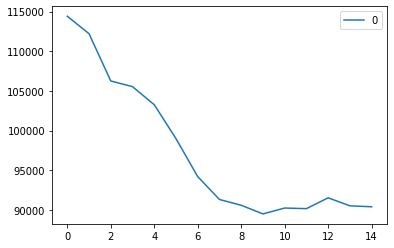

In [29]:
curve = pd.DataFrame(rmse_val)
curve.plot()

Use grid seach to find best K.

In [30]:
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(x_train, y_train)
model.best_params_

{'n_neighbors': 9}

The best K value is 9.